<a href="https://colab.research.google.com/github/artms-18/ML-Projects/blob/main/Pets_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using a Resnet50 feature extractor to classify and locate objects within the Oxford-IIIT Pet Dataset

In this notebook, we will achieve this by implementing the following steps:
1. Importing Modules
2. Preprocessing data
3. Defining helper functions to later view the data
4. Choosing a runtime strategy
4. Creating the model using a pretrained feature extractor, but not including the top so that we can add our own Dense layers
5. Compiling and fitting the model
6. Visualizing the results and looking at accuracy as well as loss on Tensorflow Hub

## Importing Modules

In [1]:
import glob
import os
import csv
import cv2
import zipfile

import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import PIL

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

In [2]:
tf.executing_eagerly()

True

## Getting the Data

In [3]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mikashaw","key":"5ea1167847d0f4828837c42bb91725e5"}'}

In [5]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d devdgohil/the-oxfordiiit-pet-dataset

 98% 768M/780M [00:08<00:00, 120MB/s]
100% 780M/780M [00:08<00:00, 98.0MB/s]


In [6]:
with zipfile.ZipFile('/content/the-oxfordiiit-pet-dataset.zip', 'r') as zip_file:
  zip_file.extractall('/content/the-oxfordiiit-pet-dataset')

## Preprocessing the Data

Right now, the annotations are in an xml file. In order to train the model, we will need to convert the data contained into a numpy array

In [7]:
XML_PATH = '/content/the-oxfordiiit-pet-dataset/annotations/annotations/xmls'
SPLIT_RATIO = 0.8 #while splitting into training and validation

In [8]:
class_names = {} #storing the name pertaining to each class of images
k = 0 #classes will be label encoded
output = [] #this will soon be a list containing the labels for each image (paht, height, width, xmin, xmas, ymax, class_name, class_names[class_name])

xml_files = glob.glob("{}/*xml".format(XML_PATH))
for i, xml_file in enumerate(xml_files):
  tree = ET.parse(xml_file)
  path = os.path.join(XML_PATH, tree.findtext("./filename"))

  height = int(tree.findtext("./size/height"))
  width = int(tree.findtext("./size/width"))
  xmin = int(tree.findtext("./object/bndbox/xmin"))
  ymin = int(tree.findtext("./object/bndbox/ymin"))
  xmax = int(tree.findtext("./object/bndbox/xmax"))
  ymax = int(tree.findtext("./object/bndbox/ymax"))

  basename = os.path.basename(path)
  basename = os.path.splitext(basename)[0]
  class_name = basename[:basename.rfind('_')].lower() #gets the lowercased name of pet (getting rid of jpg number)
  if class_name not in class_names:
    class_names[class_name] = k
    k+=1

  output.append((path, height, width, xmin, ymin, xmax, ymax, class_name, class_names[class_name]))

output.sort(key = lambda tup: tup[-1]) #sorting by class


In [9]:
#taking a look at the amounts of images in each image class

lengths = []
i = 0
last = 0
for j, row in enumerate(output):
  if last == row[-1]: #since earlier, we sorted 'output' from class 0 increasing, we can traverse the list much easier
    i += 1 #this will continue happening until last IS NOT equal to the class label
  else: 
    print(f"class {output[j-1][-2]}: {i} images") #we are doing j-1 because this happens ONLY when we move on to the next class
    lengths.append(i)
    i = 1
    last += 1

print(f"class {output[j-1][-2]}: {i} images") #since the last one still needs to be expressed
lengths.append(i)


class miniature_pinscher: 100 images
class saint_bernard: 99 images
class chihuahua: 100 images
class leonberger: 100 images
class maine_coon: 100 images
class pug: 100 images
class wheaten_terrier: 100 images
class samoyed: 99 images
class staffordshire_bull_terrier: 100 images
class keeshond: 100 images
class great_pyrenees: 100 images
class beagle: 100 images
class boxer: 100 images
class russian_blue: 100 images
class scottish_terrier: 100 images
class persian: 100 images
class bombay: 100 images
class english_setter: 100 images
class basset_hound: 100 images
class shiba_inu: 100 images
class american_bulldog: 100 images
class ragdoll: 99 images
class yorkshire_terrier: 100 images
class havanese: 100 images
class birman: 100 images
class bengal: 98 images
class american_pit_bull_terrier: 100 images
class japanese_chin: 100 images
class siamese: 100 images
class german_shorthaired: 100 images
class british_shorthair: 100 images
class english_cocker_spaniel: 100 images
class newfound

## Splitting into training and validation

In [10]:
training_data = []
validation_data = []
s = 0

for c in lengths:
  for i in range(c):
    path, height, width, xmin, ymin, xmax, ymax, class_name, class_id = output[s]
    if xmin >= xmax or ymin > ymax or xmax > width or ymax > height or xmin < 0 or ymin < 0:
      print(f"Warning: {path} contains invalid box. Skipped...")
      continue

    if i <= c * SPLIT_RATIO:
      training_data.append(output[s])

    else:
      validation_data.append(output[s])

    s+= 1
print(len(training_data))
print(len(validation_data))

2984
702


## Getting Images

In [11]:
IMG_PATH = '/content/the-oxfordiiit-pet-dataset/images/images'
IMG_PATHS = []
img_files = glob.glob("{}/*jpg".format(IMG_PATH)) #getting all the jpg files

In [12]:
img_files[0].split('/')[-1].split('.')[-2]

'Abyssinian_25'

In [13]:


images_and_labels = []

def get_image_and_label(img_files, labels):
  for i in range(len(img_files)):
    img = img_files[i].split('/')[-1].split('.')[-2]
    for j in range(len(labels)):
      label = labels[j][0].split('/')[-1].split('.')[-2]
      if img == label:
        images_and_labels.append((img_files[i], labels[j]))
        break
     
  return images_and_labels


In [14]:
ims_and_labels_training = get_image_and_label(img_files, training_data)
img_and_labels_validation = get_image_and_label(img_files, validation_data)

In [15]:
#preprocessing functions

import cv2

def convert_to_tensor(img_path):

  """

    Args: filepath to an image
    Returns: a resized RBB image with a batch dimension in the form of a tensor of dtype tf.float32

  """

  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (256,256))
  image_tensor = tf.convert_to_tensor(img, dtype = tf.float32)
  image_tensor = image_tensor / 255.0
  #image_tensor = tf.expand_dims(image_tensor, 0)
  return image_tensor

def preprocess_label(label):

  """
    Args: A label containing a tuple with values (path, height, width, xmin, ymin, xmax, ymax, class_name, class_names[class_name])
    Returns: A label containinga tuple with values (class_names[class_name], [xmin, ymin, xmax, ymax])

    **NOTE** the class_names[class_name] will be one hot encoded

  """

  path, height, width, xmin, ymin, xmax, ymax, class_name, class_label = label

  label = tf.one_hot(class_label, 37)
  b_box = [xmin, ymin, xmax, ymax]
  for i in range(len(b_box)):
    b_box[i] = b_box[i] / 255.0
  

  return label, b_box

def preprocessing(image_and_label):

  """

    Args: a list containing tuples of list[0] = image path, list[2] = outputs/labels
    Returns: a tuple containing the preprocessed images and labels

    ##MIKA FIGURE OUT HOW THE LABEL SHOULD BE FORMATTED
  
  """

  image, label = image_and_label
  preprocessed_image = convert_to_tensor(image)
  pre_label, pre_b_box = preprocess_label(label)

  return (preprocessed_image, (pre_label, pre_b_box))

def create_datasets(images_and_labels):

  images = []
  labels = []
  b_boxes = []

  for image_and_label in images_and_labels:
    image, label = preprocessing(image_and_label)
    label, b_box = label
    images.append(image)
    labels.append(label)
    b_boxes.append(b_box)

  dataset = tf.data.Dataset.from_tensor_slices((images, (labels, b_boxes)))
  dataset = dataset.shuffle(100, reshuffle_each_iteration = True)
  dataset = dataset.batch(64).prefetch(tf.data.AUTOTUNE)

  return dataset


In [16]:
training_dataset = create_datasets(ims_and_labels_training)

In [122]:
validation_dataset = create_datasets(img_and_labels_validation)

## Visualizing the Images

In [17]:
# Matplotlib config

plt.rc('image', cmap = 'gray')
plt.rc('grid', linewidth = 0)
plt.rc('xtick', top = False, bottom = False, labelsize = 'large')
plt.rc('ytick', left = False, right = False, labelsize = 'large')
plt.rc('axes', facecolor = 'F8F8F8', titlesize = 'large', edgecolor = 'white')
plt.rc('text', color = 'a8151a') 
plt.rc('figure', facecolor = 'F0F0F0') #Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


In [60]:
im_width = 75
im_height = 75

#xmin, ymin, xmax, ymax

def draw_bounding_box_on_image(image,
                                 ymin,
                                 xmin,
                                 ymax,
                                 xmax,
                                 color = 'red',
                                 thickness = 1,
                                 display_str = None,
                                 use_normalized_coordinates = False):

  """

    Args: a list with sublists of (image, label)
    Returns: a rendered image with bounding boxes

  """

  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin* im_width, 
                                  xmax * im_width,
                                  ymin * im_height,
                                  ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], 
            width=thickness, 
            fill = color)

def draw_bounding_boxes_on_image(image, 
                                 boxes,
                                 color = [],
                                 thickness = 1,
                                 display_str_list = ()):
  """
  Raises ValueError if boxes are npt a [N, 4] array
  """

  boxes_shape = boxes.shape 
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N: 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i,1], boxes[i,0], boxes[i,3], boxes[i,2])

def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color = [],
                                       thickness = 1,
                                       display_str_list = ()):
#xmin, ymin, xmax, ymax
  """

    Args: 
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.

  """

  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
  return np.array(rgbimg)

def dataset_to_numpy_util(training_dataset):

  """
      Returns: a batch from the dataset
  """

  for images, (labels, b_boxes) in training_dataset.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    numpy_labels = np.argmax(numpy_labels, axis = 1)
    numpy_b_boxes = b_boxes.numpy()

  return (numpy_images, numpy_labels, numpy_b_boxes)



In [61]:
image, label, b_box = dataset_to_numpy_util(training_dataset) #remember batch size = 64

In [62]:
image.shape

(64, 256, 256, 3)

In [63]:
image[0].shape

(256, 256, 3)

In [70]:
iou_threshold = 0.6

def display_image_with_boxes(images, 
                              predictions, 
                              labels, 
                              pred_bboxes, 
                              bboxes, 
                              iou, 
                              title):
  """
    Displays a row of images with their predictions
  """

 
  
  index = np.random.choice(len(images), size = 1)

  image = images[index]
  print(image.shape)
  image_prediction = predictions[index]
  image_label = labels[index]
  if len(iou) > 0:
      image_iou = iou[index]
  if len(pred_bboxes)>0:
      image_pred_bboxes = pred_bboxes[index,:]
  image_bboxes = bboxes[index,:]
  for i, box in enumerate(image_bboxes):
    image_bboxes[i]*=255.0
    


  image = image * 255.0
  image = image.astype(np.uint8)
  image = np.squeeze(image, axis = 0)
  print(image.shape)
  #image = image.reshape((1,75,75))
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])
  
  img_to_draw = draw_bounding_boxes_on_image_array(image, image_bboxes, color=['red', 'green'], display_str_list=["true", "pred"])
  plt.xlabel(image_prediction)
  plt.xticks([])
  plt.yticks([])
    
  if image_prediction != image_label:
    ax.xaxis.label.set_color('red')

    
    
  plt.imshow(img_to_draw)

  if len(iou) > 0 :
    color = "black"
    if (image_iou < iou_threshold):
      color = "red"
    ax.text(0.2, -0.3, "iou: %s" %(image_iou), color=color, transform=ax.transAxes)

In [71]:
image.shape

(64, 256, 256, 3)

(1, 256, 256, 3)
(256, 256, 3)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


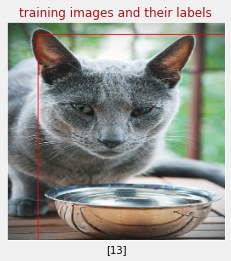

In [74]:
display_image_with_boxes(image, 
                          label,
                          label,
                          np.array([]),
                          b_box, 
                          np.array([]),
                          "training images and their labels")

## Building the Model

For this, I will be using a Pretrained ResNet50 feature extractor and will be adding my own dense and classification layers.

In [75]:
# ResNet50 model pretraining using imagenet

resnet50 = tf.keras.applications.resnet50.ResNet50(include_top = False, weights = 'imagenet', input_shape = (256,256,3,))

94773248/94765736 [==============================] - 1s 0us/step


In [76]:
for layer in resnet50.layers:
  layer.trainable = False

In [77]:
for layer in resnet50.layers[-5:]:
  layer.trainable = True

In [78]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [118]:
def resnet50_output(x):
  
  x = resnet50(x)
  return x

def classification_output(x):
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation = 'relu')(x)
  x = tf.keras.layers.Dense(37, activation = 'softmax', name = "classification")(x)

  return x

def bounding_box_output(x):
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation = 'relu')(x)
  x = tf.keras.layers.Dense(4, name = "bounding")(x)

  return x

def model():

  """

    Args: an input of shape (batch_dim, 256, 256, 3)

    Returns: 
        2 outputs: 
            1. A classification output
            2. A bounding box prediction output
  """
  inputs = tf.keras.Input(shape = (256,256,3,))
  x = resnet50_output(inputs)
  classification = classification_output(x)
  bounding = bounding_box_output(x)

  model = tf.keras.Model(inputs = inputs, outputs = [classification, bounding])
  model.summary()

  return model 

  

In [119]:
model = model()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 8, 8, 2048)   23587712    input_13[0][0]                   
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 131072)       0           resnet50[4][0]                   
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 131072)       0           resnet50[4][0]                   
____________________________________________________________________________________________

## Callback Function

## Compiling and fitting the model

In [121]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = ['categorical_crossentropy', 'mae'], metrics = ['accuracy'])

In [ ]:
model.fit(training_dataset, epochs = 25, validation_data = validation_dataset)